# Running infercnvpy on Janesick et al. 2023 
[High resolution mapping of the tumor microenvironment using integrated single-cell, spatial and in situ analysis](https://www.nature.com/articles/s41467-023-43458-x).

Before running the tutorial, please download the data into the `data` folder. 
e.g.

```bash
cd data/
wget https://cdn.10xgenomics.com/raw/upload/v1695234604/Xenium%20Preview%20Data/Cell_Barcode_Type_Matrices.xlsx
wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/CytAssist_FFPE_Human_Breast_Cancer/CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
``` 
This tutorial is based on the tutorial provided by [infercnvpy](https://infercnvpy.readthedocs.io/en/latest/notebooks/tutorial_3k.html)

## Imports

In [37]:

import pandas as pd
import scanpy as sc
from collections import Counter
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter("ignore")

## Load the data

In [15]:
adata = sc.read_10x_h5('../data/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

/data/olga/anaconda3/envs/torch_gnn/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
cell_type = pd.read_excel("../data/Cell_Barcode_Type_Matrices.xlsx", sheet_name="scFFPE-Seq", index_col = 0)

In [17]:
adata.obs = adata.obs.join(cell_type)
adata = adata[~adata.obs.Annotation.isna()]

## Prepare the data for inferCNV
We will not filter out cells as we use only annotated cells.
We also won't exclude genes as inferCNVpy operates on binned genomic regions.

### Normalization

In [18]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

/data/olga/anaconda3/envs/torch_gnn/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Adding genomic coordinates for genes from GRCH38 assembly

In [20]:
gene_list = pd.read_csv("../data/gene_list", sep = "\t", header = None)
gene_list.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14409,.,+,.,ID=ENSG00000223972.5;gene_id=ENSG00000223972.5...
1,chr1,HAVANA,gene,14404,29570,.,-,.,ID=ENSG00000227232.5;gene_id=ENSG00000227232.5...
2,chr1,ENSEMBL,gene,17369,17436,.,-,.,ID=ENSG00000278267.1;gene_id=ENSG00000278267.1...
3,chr1,HAVANA,gene,29554,31109,.,+,.,ID=ENSG00000243485.5;gene_id=ENSG00000243485.5...
4,chr1,ENSEMBL,gene,30366,30503,.,+,.,ID=ENSG00000284332.1;gene_id=ENSG00000284332.1...


In [21]:
genes = []
for tup in gene_list.itertuples():
    try:
        info = tup[9].split(";")
        for i in info:
            label,val = i.split("=")
            if label == "gene_name":
                gene = val
    except:
        gene = ""
    genes.append(gene)
gene_list.index = genes
gene_list = gene_list[[0,3,4]]
gene_list.columns = ["chromosome","start","end"]
gene_list = gene_list.drop_duplicates()
gene_list = gene_list.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

In [22]:
adata = adata[:,list(set(adata.var.index).intersection(gene_list.index))]
adata.var = adata.var.join(gene_list, how = "left")

In [23]:
adata

AnnData object with n_obs × n_vars = 27460 × 17389
    obs: 'Annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'chromosome', 'start', 'end'
    uns: 'log1p'

## Running inferCNV

### Select reference cell types

In [24]:
ref_cells = ['Stromal', 'Macrophages 1', 'Perivascular-Like',
       'CD4+ T Cells',  'CD8+ T Cells', 'Endothelial', 'Macrophages 2', 'B Cells', 'Stromal & T Cell Hybrid',
       'IRF7+ DCs', 'Mast Cells', 'LAMP3+ DCs']

### Exclude chrX, chrY and chrM

In [25]:
adata = adata[:,adata.var[~adata.var.chromosome.isin(["chrX","chrY","chrM"])].index]

In [26]:
cnv.tl.infercnv(
    adata = adata,
    reference_key="Annotation",
    reference_cat=ref_cells,
    window_size=250,
    step=1,
    n_jobs = 10
)

100%|██████████| 6/6 [00:44<00:00,  7.35s/it]


... storing 'Annotation' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: B Cells, CD4+ T Cells, CD8+ T Cells, etc.
var_group_labels: chr1, chr2, chr3, etc.


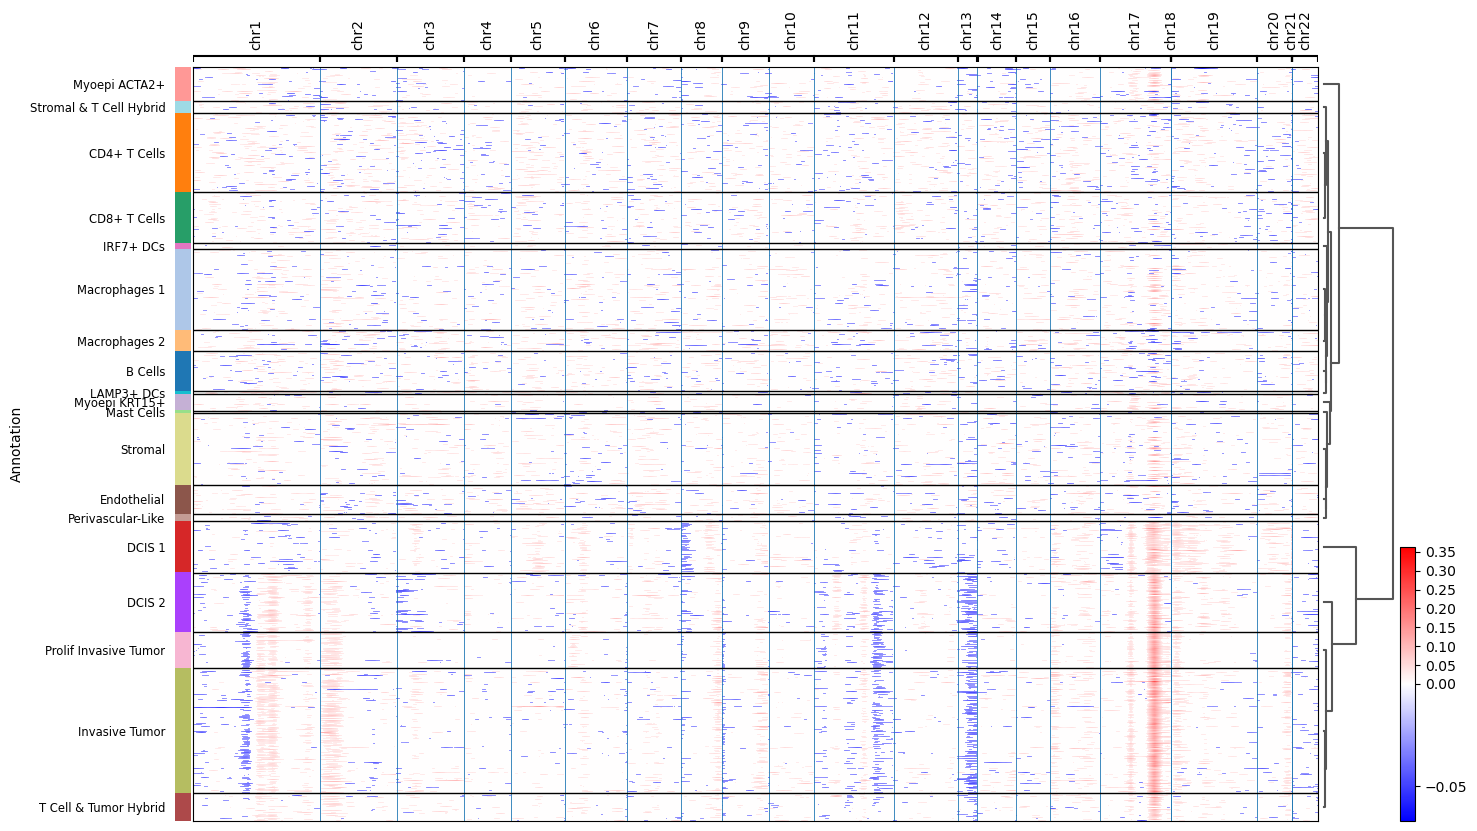

In [28]:
cnv.pl.chromosome_heatmap(adata, groupby="Annotation", dendrogram=True)


## Clustering by CNV profiles and identifying tumor cells

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


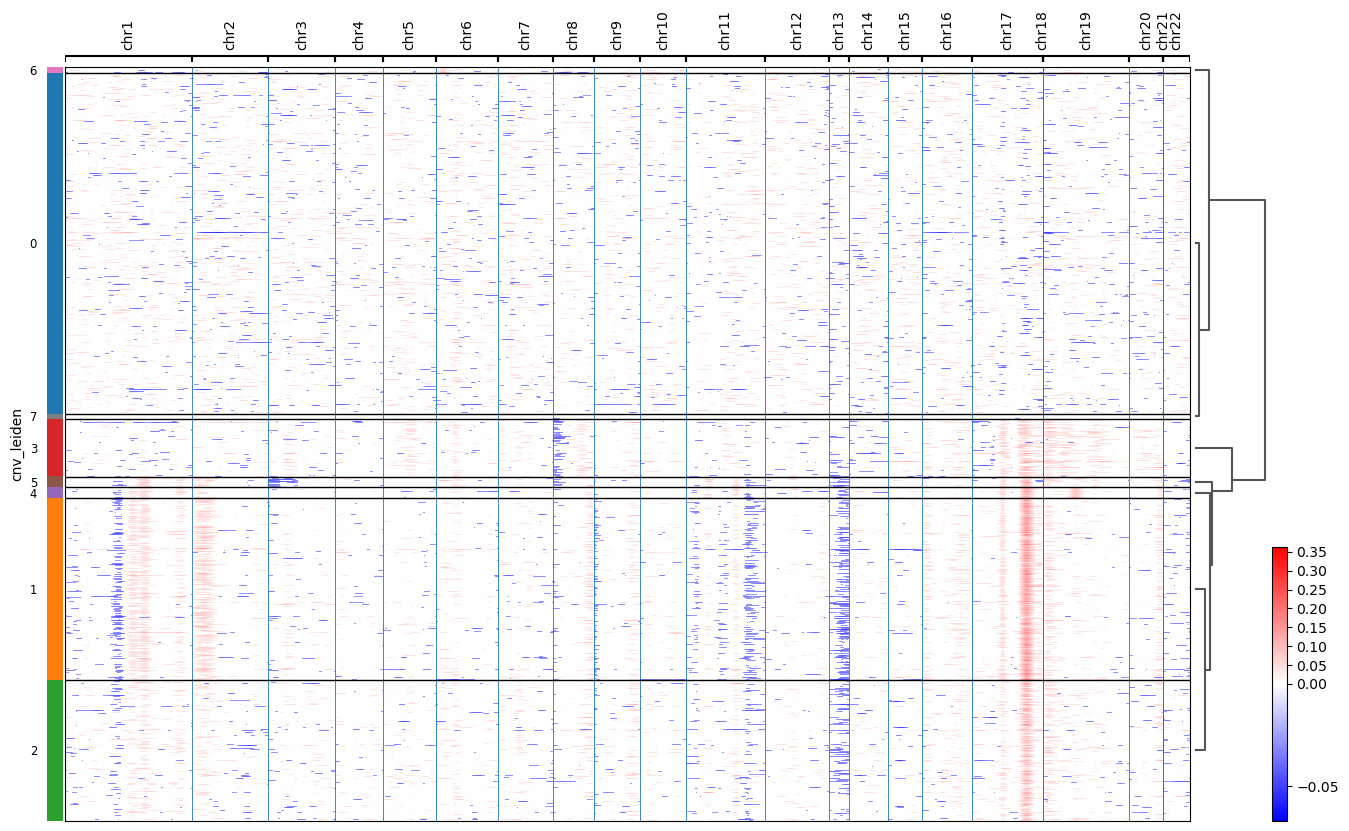

In [34]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata, resolution=0.5)
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)


In [33]:
del adata.uns["cnv_leiden_colors"]
del adata.uns["dendrogram_cnv_leiden"]

## UMAP plot of CNV profiles

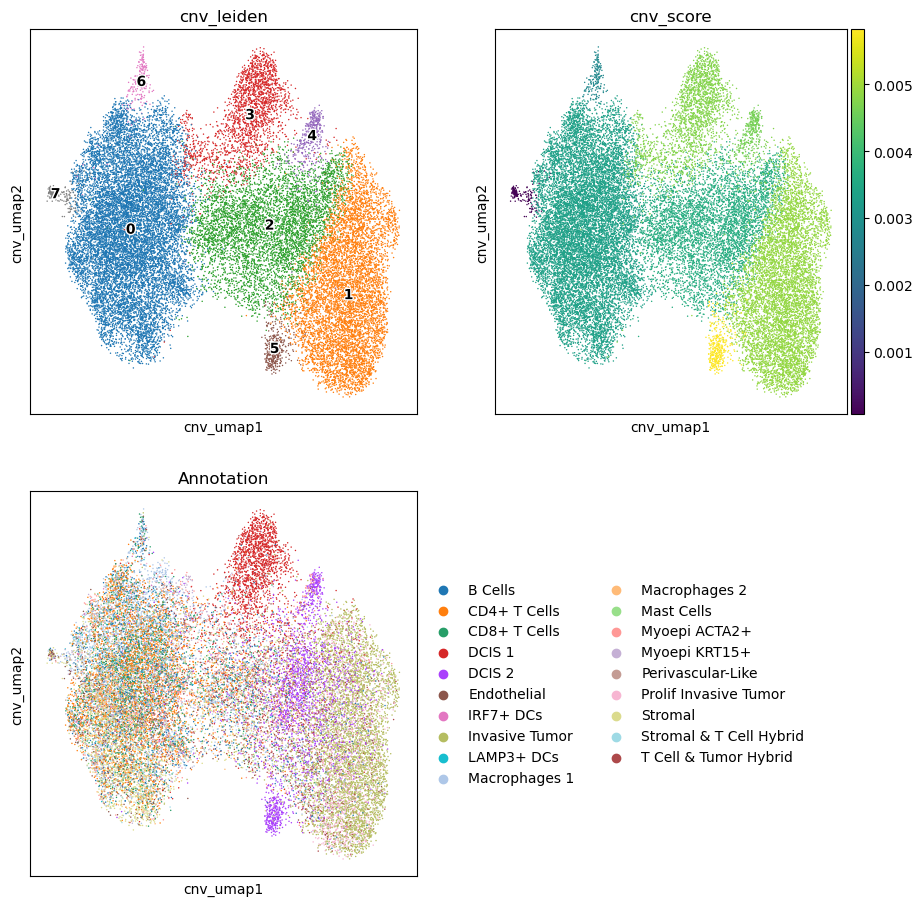

In [35]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="Annotation", ax=ax3)

###  We define threshold based on the visual inspection of the UMAP plot at 0.0035

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


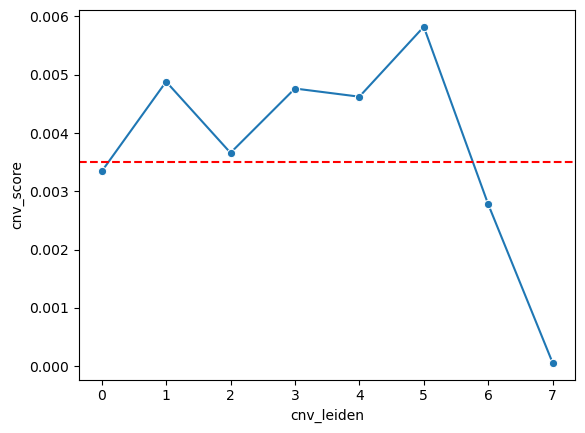

In [45]:
sns.lineplot(adata.obs[["cnv_leiden","cnv_score"]].groupby("cnv_leiden").mean().reset_index(),
             x = "cnv_leiden", y = "cnv_score", marker = "o")
plt.axhline(0.0035, color='r', linestyle='--', label = "Threshold")
plt.show()

We rename clusters such that the ones bellow threshold are considered diploid and others are numbered from 0 to 5

In [46]:
rename = {}
clusters = adata.obs[["cnv_leiden","cnv_score"]].groupby("cnv_leiden").mean()
counter = 0
for i in clusters.index:
    if clusters.loc[i,"cnv_score"] > 0.0035:
        rename[i] = str(counter)
        counter += 1
    else:
        rename[i] = "diploid"

In [48]:
adata.obs["clone"] = adata.obs.cnv_leiden.map(rename)

... storing 'clone' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


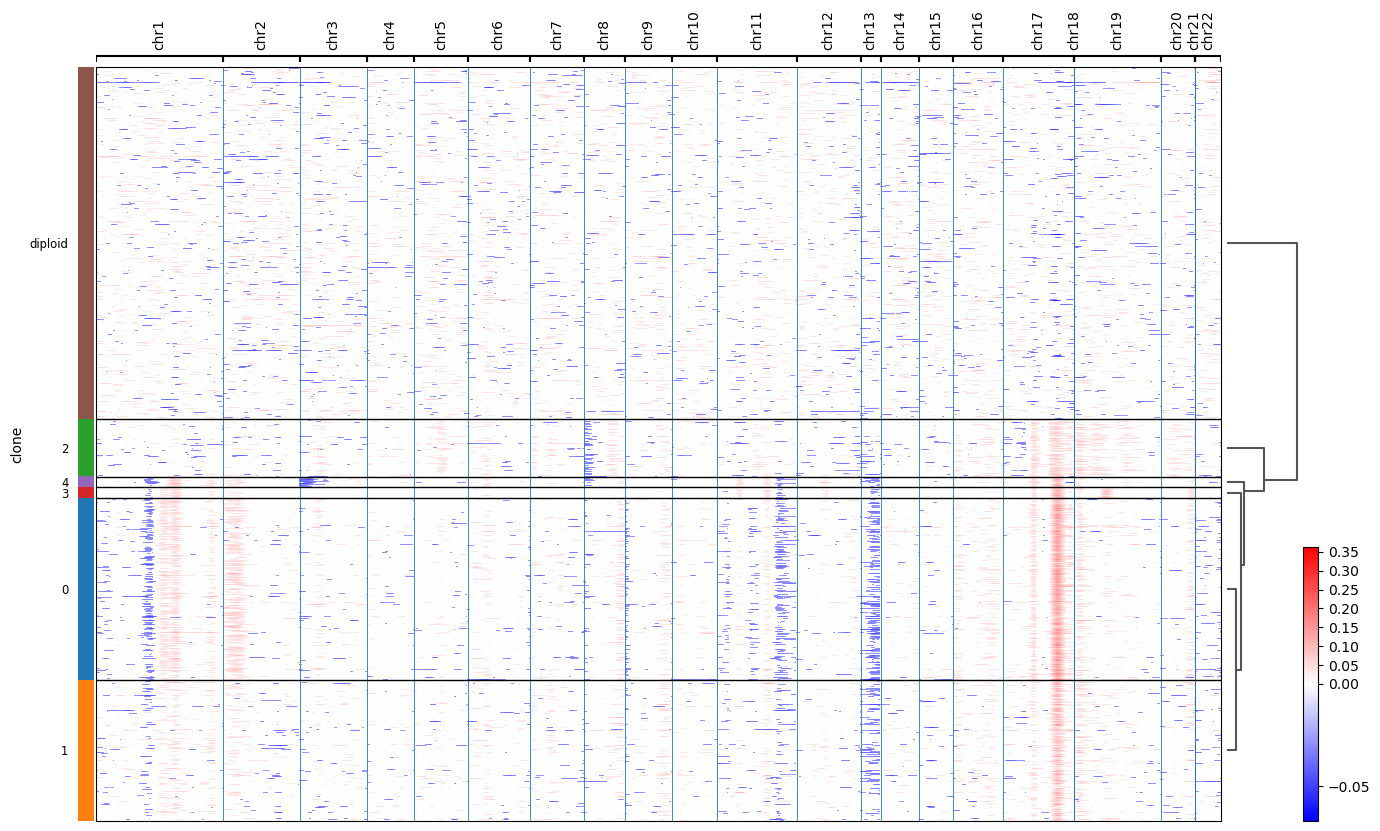

In [49]:
cnv.pl.chromosome_heatmap(adata, groupby="clone", dendrogram=True)


Saving the annotation file

In [50]:
adata.obs["clone"].to_csv("../data/clone_annotation.csv")